# Carga de Bases Inferidas

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd


In [3]:
smart_inferidos = pd.read_csv('base_entrenamiento.csv', delimiter= ',')

In [4]:
len(smart_inferidos)

4096508

In [3]:
stops = pd.read_csv('POI_DATA/paradas_enriquecidas.csv', sep = ',')
stops = stops.drop(columns=['LINEA', 'COMPA???', 'SENTIDO', 'SECUENCIA', 'PARADA', 'ID-PROX PA', 'PARADA2'])

In [4]:
recuento =  pd.read_csv('POI_DATA/recuento_por_categoria.csv', sep = ',')

In [48]:
stops_sin_duplicados = stops.drop_duplicates(subset=['ID-PARADA'], keep='first')


Se reagrupan las categorias de recuento para reducir la cantidad y disminuir la dispersion.

In [5]:
# Definir las agrupaciones
agrupaciones = {
    'recreation': ['leisure_swimming_pool', 'amenity_cinema', 'leisure_park', 'shop_mall'],
    'public_utility': ['amenity_bench', 'amenity_atm'],
    'food_drink': ['amenity_cafe', 'amenity_bar'],
    'education': ['amenity_college', 'amenity_university']
}

# Crear una nueva columna 'categoria_agrupada' basada en las agrupaciones
def asignar_categoria(layer):
    for categoria, valores in agrupaciones.items():
        if layer in valores:
            return categoria
    return layer  # Si no está en ninguna agrupación, conserva su valor original

# Aplicar la función al DataFrame
recuento['categoria_agrupada'] = recuento['layer'].apply(asignar_categoria)

# Agrupar por la nueva categoría y sumar las cantidades
df_agrupado = recuento.groupby('categoria_agrupada', as_index=False)['cantidad'].sum()


                             categoria_agrupada  cantidad
0                             amenity_fast_food       262
1          amenity_hospital_healthcare_hospital        49
2   amenity_place_of_worship_religion_christian       169
3                            amenity_restaurant       832
4                                amenity_school       129
5                                     education        50
6                                    food_drink       315
7                            landuse_industrial         7
8                           landuse_residential        37
9                                public_utility       188
10                                   recreation        38
11                                tourism_hotel       136


df_agrupado contiene el conteo de los POIs en Cuenca

In [ ]:
agrupaciones = {
    'recreation': ['leisure_swimming_pool', 'amenity_cinema', 'leisure_park', 'shop_mall'],
    'public_utility': ['amenity_bench', 'amenity_atm'],
    'food_drink': ['amenity_cafe', 'amenity_bar'],
    'education': ['amenity_college', 'amenity_university']
}

In [8]:
# Sumar las columnas de cada grupo y crear nuevas columnas
for nueva_categoria, columnas in agrupaciones.items():
    # Verificar qué columnas existen en el DataFrame (por si alguna no está presente)
    columnas_existentes = [col for col in columnas if col in stops.columns]
    if columnas_existentes:  # Si hay al menos una columna válida
        stops[nueva_categoria] = stops[columnas_existentes].sum(axis=1)

# Opcional: Eliminar las columnas originales agrupadas (si ya no las necesitas)
columnas_a_eliminar = [col for grupo in agrupaciones.values() for col in grupo if col in stops.columns]
stops = stops.drop(columns=columnas_a_eliminar)

In [13]:
df_agrupado

,categoria_agrupada,cantidad
0,amenity_fast_food,262
1,amenity_hospital_healthcare_hospital,49
2,amenity_place_of_worship_religion_christian,169
3,amenity_restaurant,832
4,amenity_school,129
5,education,50
6,food_drink,315
7,landuse_industrial,7
8,landuse_residential,37
9,public_utility,188


In [23]:
# 1. Definir las columnas a normalizar (las que mencionaste)
columnas_a_normalizar = [
    'amenity_fast_food',
    'amenity_hospital_healthcare_hospital',
    'amenity_place_of_worship_religion_christian',
    'amenity_restaurant',
    'amenity_school',
    'landuse_industrial',
    'landuse_residential',
    'tourism_hotel',
    'recreation',
    'public_utility',
    'food_drink',
    'education',
    'leisure_swimming_pool',
    'amenity_cinema',
    'amenity_bench'
]

# 2. Verificar qué columnas existen en 'stops' (evitar errores)
columnas_existentes = [col for col in columnas_a_normalizar if col in stops.columns]

# 3. Extraer los totales desde 'df_agrupado' (asumiendo estructura: categoria | total)
totales = df_agrupado.set_index('categoria_agrupada')['cantidad'].to_dict()

# 4. Normalizar las columnas en 'stops'
for columna in columnas_existentes:
    if columna in totales and totales[columna] != 0:  # Evitar división por cero
        stops[columna] = stops[columna] / totales[columna]
    else:
        stops[columna] = 0  # o np.nan si prefieres

In [31]:
stops = stops.rename(columns={'full_id': 'CodigoZona'})


In [63]:
columnas_a_transferir = [
    'total_pois',
    'amenity_fast_food',
    'amenity_hospital_healthcare_hospital',
    'amenity_place_of_worship_religion_christian',
    'amenity_restaurant',
    'amenity_school',
    'landuse_industrial',
    'landuse_residential',
    'tourism_hotel',
    'recreation',
    'public_utility',
    'food_drink',
    'education',
    'leisure_swimming_pool',
    'amenity_cinema',
    'amenity_bench',
    'CodigoZona'
]

In [64]:
smart_inferidos = smart_inferidos.merge(
    stops_sin_duplicados[['ID-PARADA'] + columnas_a_transferir],
    left_on='ParadaAscenso_Nombre',
    right_on='ID-PARADA',
    how='left'  # Mantiene todos los duplicados originales de smart_inferidos
)

In [65]:
smart_inferidos = smart_inferidos.drop(columns=['ID-PARADA'])


In [66]:
smart_inferidos = smart_inferidos.rename(columns={'ParadaDescenso_Inferida': 'Destino'})

In [67]:
smart_inferidos

,CodigoTarjeta,FechaHoraAscenso,ParadaAscenso_Nombre,LineaViaje,ParadaRegreso,FechaHoraRegreso,Destino,total_pois,amenity_fast_food,amenity_hospital_healthcare_hospital,...,landuse_residential,tourism_hotel,recreation,public_utility,food_drink,education,leisure_swimming_pool,amenity_cinema,amenity_bench,CodigoZona
0,CURA0000320842,2023-10-20 15:25:41,2639,5002,1760,2023-10-20 18:34:18,1878,168,0.091603,0.000000,...,0.108108,0.036765,0.078947,0.122340,0.028571,0.14,0,0,0,r3845861
1,CURA0000357796,2023-10-02 07:31:38,3034,2002,2742,2023-10-02 17:24:32,2832,168,0.091603,0.000000,...,0.108108,0.036765,0.078947,0.122340,0.028571,0.14,0,0,0,r3845861
2,CURA0000435467,2023-10-15 12:03:54,2618,5001,3127,2023-10-15 14:09:16,3997,247,0.198473,0.020408,...,0.000000,0.051471,0.000000,0.058511,0.155556,0.26,0,0,0,r3845848
3,CURA0010000028,2023-10-11 14:19:39,1958,7001,1363,2023-10-11 18:38:39,1315,79,0.038168,0.102041,...,0.000000,0.102941,0.000000,0.047872,0.031746,0.00,0,0,0,r3845814
4,CURA0010000028,2023-10-13 09:02:59,1721,7001,1879,2023-10-13 18:45:21,1951,193,0.057252,0.040816,...,0.000000,0.235294,0.026316,0.063830,0.168254,0.04,0,0,0,r3845817
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4096503,CURS0030329401,2023-10-28 12:58:51,721,9101,721,2023-10-28 12:58:45,712,214,0.099237,0.040816,...,0.297297,0.022059,0.078947,0.095745,0.101587,0.02,0,0,0,r3845828
4096504,CURS0030329401,2023-10-30 13:59:25,1790,6007,721,2023-10-30 09:43:46,712,80,0.041985,0.000000,...,0.000000,0.022059,0.026316,0.037234,0.012698,0.06,0,0,0,r3845764
4096505,CURS0300000004,2023-10-02 17:36:30,2317,1003,794,2023-10-02 15:00:36,830,193,0.057252,0.040816,...,0.000000,0.235294,0.026316,0.063830,0.168254,0.04,0,0,0,r3845817
4096506,CURS0300000004,2023-10-14 16:53:20,2353,1003,794,2023-10-14 12:02:28,830,331,0.099237,0.020408,...,0.000000,0.345588,0.184211,0.101064,0.238095,0.12,0,0,0,r3845816


In [68]:
smart_inferidos.to_csv('base_total_DL.csv', index = False)

## Distribucion

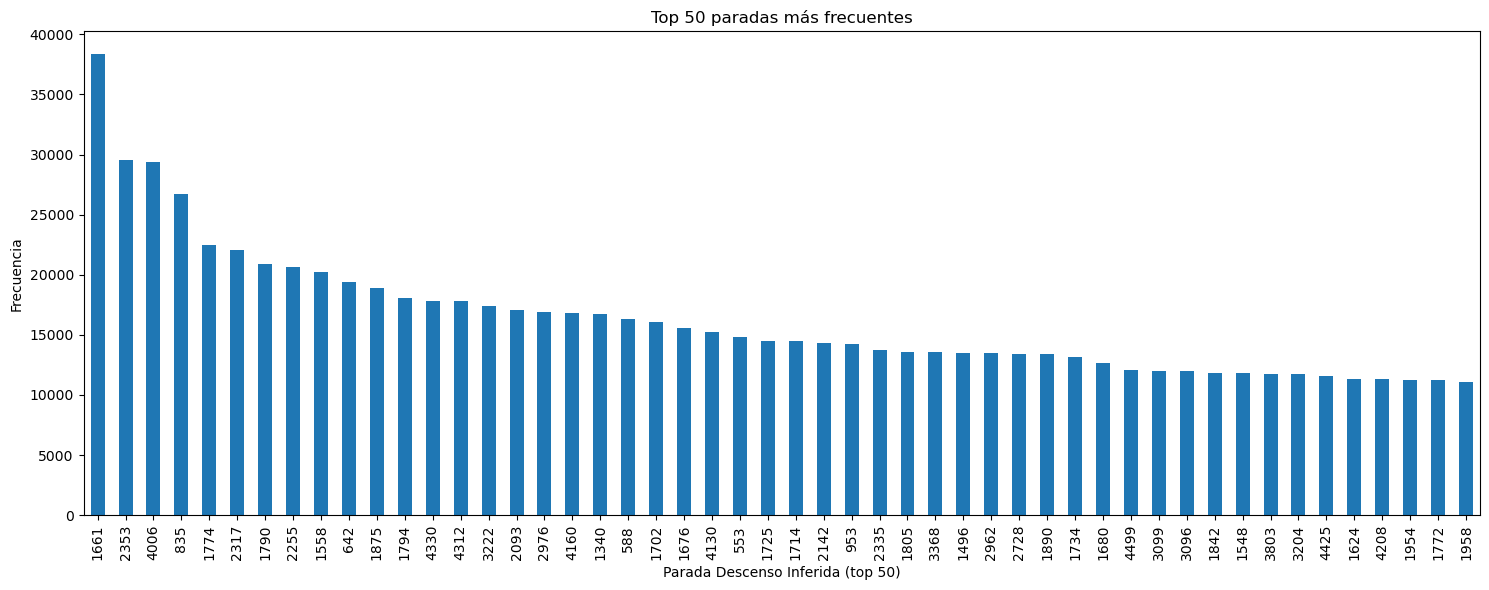

In [14]:
plt.figure(figsize=(15, 6))
frecuencias.head(50).plot(kind='bar')
plt.xlabel('Parada Descenso Inferida (top 50)')
plt.ylabel('Frecuencia')
plt.title('Top 50 paradas más frecuentes')
plt.tight_layout()
plt.show()


6667171 entre 2 y 6 viajes por dia

740350 destinos para 2 registros por dia

478023 destinos para 3 registros por dia

868504 destinos para 4 registros por dia

232245 para 5 registros por dia

Existen 201987 registros con dias consecutivos de 2395302 posibles retornos.

In [69]:
frecuencias = smart_inferidos['ParadaDescenso_Inferida'].value_counts()
proporcion_acumulada = frecuencias.cumsum() / frecuencias.sum()
num_paradas_80 = (proporcion_acumulada <= 0.80).sum()
print(f"Se necesitan las {num_paradas_80} paradas más frecuentes para cubrir el 80% de los datos.")


Se necesitan las 552 paradas más frecuentes para cubrir el 80% de los datos.


In [70]:
# Paso 1: Obtener el total de registros y el umbral del 80%
total_registros = len(smart_inferidos)
umbral_80 = total_registros * 0.8

# Paso 2: Calcular frecuencias y acumulado
frecuencias = smart_inferidos['ParadaDescenso_Inferida'].value_counts()
frecuencia_acumulada = frecuencias.cumsum()

# Paso 3: Encontrar la última parada dentro del 80%
paradas_80 = frecuencia_acumulada[frecuencia_acumulada <= umbral_80]
ultima_parada = paradas_80.index[-1]
frecuencia_ultima_parada = frecuencias[ultima_parada]

print(f"La última parada dentro del 80% es: {ultima_parada}")
print(f"Con una frecuencia de: {frecuencia_ultima_parada}")


La última parada dentro del 80% es: 712
Con una frecuencia de: 2178


## Base de Puntos de Interes

In [45]:
# 1. Cargar las capas
parroquias = gpd.read_file("parroquias_intersecado_pois.gpkg")
pois = gpd.read_file("POIs_fusionados.gpkg")
paradas = gpd.read_file("paradas_geometria.gpkg")

In [4]:
# 3. Join espacial: POIs dentro de parroquias
pois_en_parroquias = gpd.sjoin(pois, parroquias, how="inner", predicate="within")

In [14]:
# 4. Conteo total de POIs por parroquia (usando 'full_id_right')
conteo_total = pois_en_parroquias.groupby("full_id_right").size().reset_index(name='total_pois')

# 5. Conteo por tipo de POI (columna 'layer')
conteo_por_tipo = pois_en_parroquias.groupby(["full_id_right", "layer"]).size().reset_index(name='cantidad')

# 6. Renombrar para poder unir con parroquias
conteo_total = conteo_total.rename(columns={"full_id_right": "full_id"})
conteo_por_tipo = conteo_por_tipo.rename(columns={"full_id_right": "full_id"})


In [32]:
paradas = paradas.drop(columns=['full_id', 'osm_id', 'wikipedia'])


In [46]:
# 2. Excluir las parroquias grandes
ids_a_excluir = ["r107724", "r107886", "r3693133"]
parroquias_filtradas = parroquias[~parroquias["full_id"].isin(ids_a_excluir)]

# 4. Join espacial: obtener el full_id de la parroquia correspondiente a cada parada
paradas_con_parroquia = gpd.sjoin(paradas, parroquias_filtradas[["full_id", "geometry"]], how="left", predicate="within")

# 5. Limpiar columnas si quieres
paradas_con_parroquia = paradas_con_parroquia.drop(columns=["index_right"])

In [51]:
paradas_enriquecidas = paradas_con_parroquia.merge(conteo_total, on="full_id", how="left")

In [55]:
recuento_por_categoria = pois['layer'].value_counts().reset_index()
recuento_por_categoria.columns = ['layer', 'cantidad']


In [58]:
conteo_pivot = conteo_por_tipo.pivot_table(
    index='full_id',
    columns='layer',
    values='cantidad',
    fill_value=0
).reset_index()


In [60]:
# Unir total_pois
paradas_enriquecidas = paradas_con_parroquia.merge(conteo_total, on='full_id', how='left')

# Unir conteo por tipo (columnas por categoría)
paradas_enriquecidas = paradas_enriquecidas.merge(conteo_pivot, on='full_id', how='left')


In [63]:
paradas_enriquecidas.to_csv('POI_DATA/paradas_enriquecidas.csv', index = False)

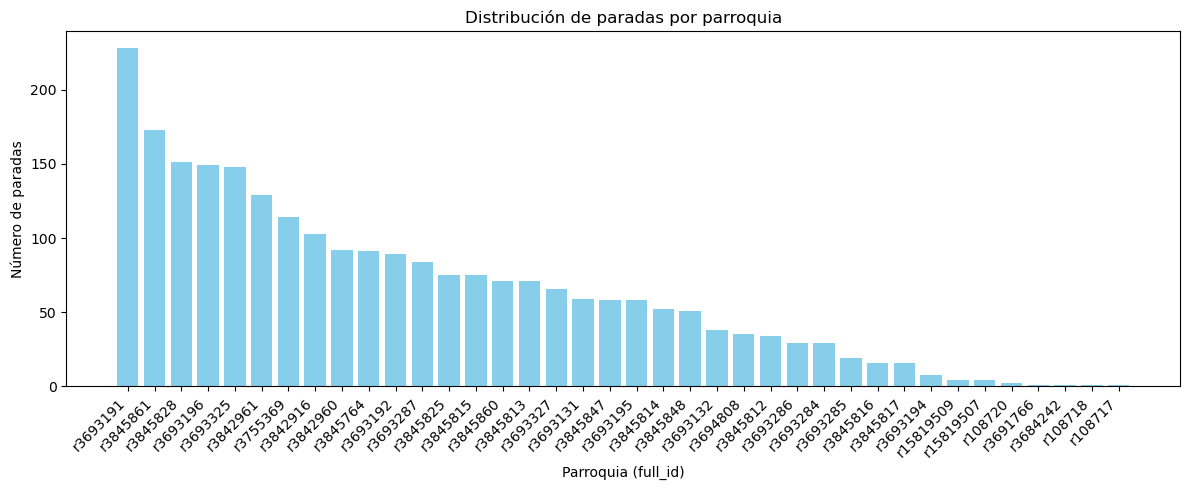

In [73]:
# Agrupar y contar paradas por parroquia
distribucion_paradas = (
    paradas_con_parroquia.groupby('full_id')['ID-PARADA']
    .count()
    .reset_index()
    .rename(columns={'ID-PARADA': 'n_paradas'})
)

# Ordenar por cantidad de paradas (opcional, para mejor visualización)
distribucion_paradas = distribucion_paradas.sort_values('n_paradas', ascending=False)

# Gráfico de barras
plt.figure(figsize=(12, 5))
plt.bar(distribucion_paradas['full_id'], distribucion_paradas['n_paradas'], color='skyblue')
plt.xlabel('Parroquia (full_id)')
plt.ylabel('Número de paradas')
plt.title('Distribución de paradas por parroquia')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [77]:
# Recuento de paradas por parroquia
clase_counts = paradas_con_parroquia['full_id'].value_counts()

# Proporción relativa
clase_relativa = clase_counts / clase_counts.sum()

# Ver la relación entre clases
ratio = clase_counts.max() / clase_counts.mean()
print(f"Razón clase mayoritaria/minoritaria: {ratio:.2f}")


Razón clase mayoritaria/minoritaria: 3.57


In [76]:
clase_counts.mean()

63.81578947368421